# start

In [1]:
from glob import iglob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
from seaborn import color_palette


import torch
from torch import nn

As tarefas mais clássicas de visão computacional com o uso de deep learning são: classificação de imagem, detecção de objetos, e segmentação semânticas.

Todas tarefas de visão computacional tem como entrada imagens, os algoritmos clássicos de visão para as tarefas mencionadas acima podiam até performar razoável, contudo sua performance era muito condicionada a um ambiente controlado, isto é, as imagens trabalhados pelo algoritmos, tanto para tunar o algoritmo, como para usá-lo em produção (ambientes de testes) tinham que ter características muito próximas, isto é, coisas como um plano de fundo parecido, iluminação parecido, o objeto central da imagem tinha que estar numa pose similar, posição similar.

Uma das façanhas de *deep learning* foi além de atingir nivéis de acurácias nunca antes visto, atender também uma ampla gama de situaçãoes, isto é, uma solução com uma grande capacidade de generalização.

Neste notebook, serão demonstrado alguns das arquiteturas mais clássicas de deep learning para as 3 principais tarefas de visão computacional com uso de pytorch, que é a principal biblioteca de deep learning hoje em dia, tanto para trabalhos acadêmico como para produtos comerciais.

# Aprendizado profundo e Redes Neurais

Redes Neurais datam desde a invenção do Perceptron, e entre várias desenvolvimentos do algortimo, a ideia principal continua a mesma. Onde uma função que mapeia valores entre X -> Y é aprendida a partir da somatória de pesos, e este pesos são aprendidos em um processo iterativo de otimização.

O aprendizado profundo nada mais é que um acumúlo de camadas intermediárias deste pesos, o que habilita a rede aprender vários níveis de caracterícas dos dados, como características geométricas (baixo-nível) e ou semânticas (alto-nível) do objeto. Características geométricas, por exemplo, são centro de massa do objeto, ângulos do eixo do objeto, o tamanho do perímetro do objeto. Características semânticas, por exemplo, são a detecção de atributos do objeto, como, o objeto tem cauda? o objeto de rodas? se, sim, quantas rodas? Essa capacidade que uma rede neural começa a ter com o uso de camadas intermediárias é chamada de *representation learning*. O que acaba tornando desnecessário, a criação manual dessas características - processo chamado de *feature engineering* -. AlexNet é um marco recente na história de deep learning tinham 8 camadas intermediárias (5 camadas de convolução e 3 camadas densas).

# Classificação de Imagens

A tarefa de classificação de imagem é a tarefa de assinalar uma categoria a uma imagem. A categoria pode ser a definição do objeto principal da imagem como um bicho (cão, gato), ou até sobre o tipo de superfície da pista como veremos no nosso exemplo. 

No nosso exemplo, faremos uso do dataset [RTK](https://data.mendeley.com/datasets/fxy5khmhpb/1), desenvolvido em um dos laboratórios do departamento, o Lapix.



In [2]:
# Road Traversing Knowledge for Quality Classification
# !wget https://data.mendeley.com/public-files/datasets/ffwgjdfn86/files/544006e3-1f21-47b3-944b-33316ff72d34/file_downloaded

# Road Traversing Knowledge for Surface Classification
# !wget https://data.mendeley.com/public-files/datasets/fxy5khmhpb/files/377da208-5a82-4602-bba5-3a2316101bc0/file_downloaded

Para a tarefa de classificação de superfície/qualidade, existem 8 classes, as amostras de cada classe estão guardadas no subdiretório com o respectivo nome.

In [3]:
!ls RoadQualityClassification/

asphalt_bad   asphalt_regular  paved_good     unpaved_bad
asphalt_good  paved_bad        paved_regular  unpaved_regular


In [4]:
impaths = np.array(list(iglob('RoadQualityClassification/**/*.jpg', recursive=True)))
nsamples = len(impaths)
print(f'Total of samples: {nsamples}')

Total of samples: 6297


Depois de baixo o dataset, precisamos organizá-lo em amostras de treinamento / validação. A rede neural profunda por ser um algoritmo por ter milhões de parâmetros, pode simplesmente memorizar o dataset de treinamento. O conjunto de validação é importante para checarmos a capacidade de generalização da rede.

In [5]:
nsamples_val = 100
nsamples_train = nsamples - nsamples_val

valpaths_ix = np.random.choice(nsamples, size=nsamples_val, replace=False)
trainpaths_ix = [i for i in np.arange(nsamples) if i not in valpaths_ix]

trainpaths = impaths[trainpaths_ix]
valpaths = impaths[valpaths_ix]

print(f'Total of train-samples: {nsamples_train}')
print(f'Total of val-samples: {len(valpaths_ix)}')

Total of train-samples: 6197
Total of val-samples: 100


Em seguida, criamos um dataframe pra nos ajudarmos a organizarmos esses dados, assim como ajudar a amostrar um exemplo de cada classe a fim de plotar o mesmo.

In [6]:
dfrtk = pd.concat([
    pd.DataFrame({'fpath': trainpaths, 'set': 'train'}),
    pd.DataFrame({'fpath': valpaths, 'set': 'val'}),
])


dfrtk['classname'] = dfrtk['fpath'].apply(lambda x: x.split('/')[-2])
dfrtk.sample(2)

,fpath,set,classname
726,RoadQualityClassification/asphalt_regular/0000...,train,asphalt_regular
79,RoadQualityClassification/unpaved_regular/0000...,val,unpaved_regular


In [7]:
dfrtk.sort_values('classname').groupby('classname').sample(1)

,fpath,set,classname
5506,RoadQualityClassification/asphalt_bad/00000012...,train,asphalt_bad
1430,RoadQualityClassification/asphalt_good/0000016...,train,asphalt_good
637,RoadQualityClassification/asphalt_regular/0000...,train,asphalt_regular
872,RoadQualityClassification/paved_bad/000000111.jpg,train,paved_bad
4874,RoadQualityClassification/paved_good/000000672...,train,paved_good
5888,RoadQualityClassification/paved_regular/000000...,train,paved_regular
2959,RoadQualityClassification/unpaved_bad/00000016...,train,unpaved_bad
3622,RoadQualityClassification/unpaved_regular/0000...,train,unpaved_regular


A imagens abaixo exemplificam as classes na seguinte ordem: ['asphalt_bad' 'asphalt_good' 'asphalt_regular' 'paved_bad' 'paved_good'
 'paved_regular' 'unpaved_bad' 'unpaved_regular'].


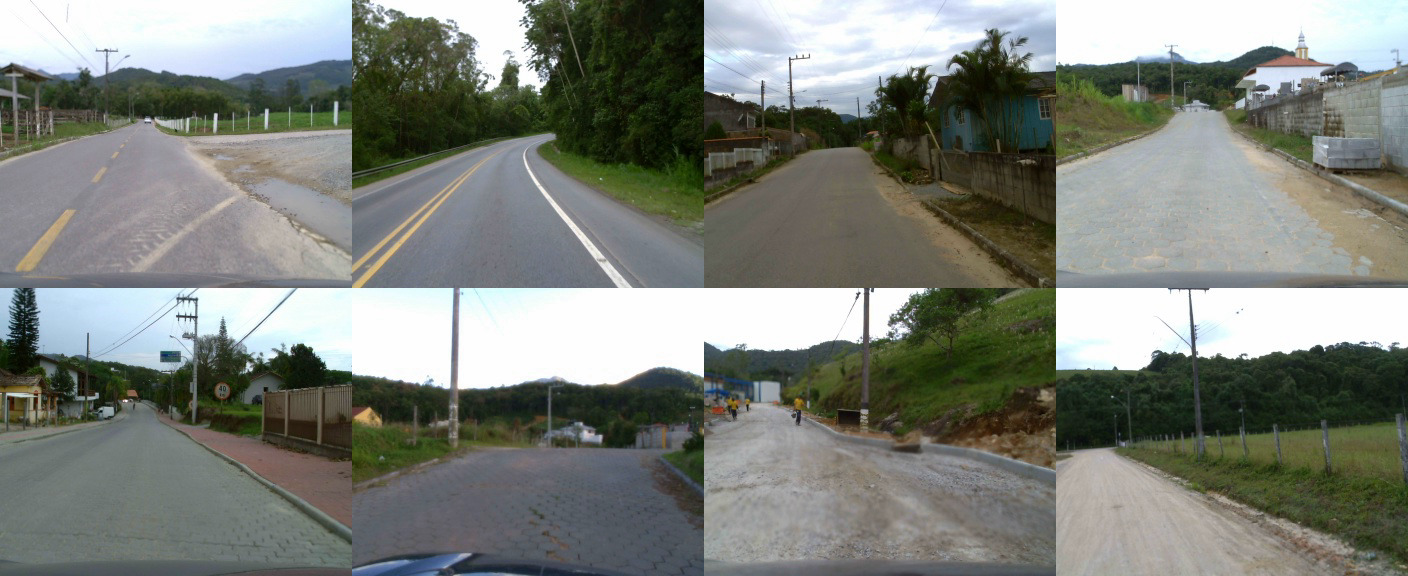

In [8]:
samples = dfrtk.sort_values('classname').groupby('classname').sample(1)
print(f'A imagens abaixo exemplificam as classes na seguinte ordem: {samples.classname.values}.')

ims = list(map(lambda x: cv2.imread(x)[..., ::-1], samples.fpath.values))
ims = [np.concatenate(ims[:4], axis=1),np.concatenate(ims[4:], axis=1)]
ims = np.concatenate(ims, axis=0)
Image.fromarray(ims)

Pra treinar uma rede em PyTorch, precisamos instanciar classes Dataset e DataLoader dessa biblioteca, veja o exemplo abaixo.

In [10]:
classnames = [
    'asphalt_bad', 'asphalt_good', 'asphalt_regular', 'paved_bad',   
    'paved_good', 'paved_regular', 'unpaved_bad', 'unpaved_regular'
]


class2id = {cl:i for i, cl in enumerate(classnames)}
id2class = {i:cl for i, cl in enumerate(classnames)}
print(class2id)

{'asphalt_bad': 0, 'asphalt_good': 1, 'asphalt_regular': 2, 'paved_bad': 3, 'paved_good': 4, 'paved_regular': 5, 'unpaved_bad': 6, 'unpaved_regular': 7}


In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T


class SimpleDataset(Dataset):
    
    def __init__(self, impaths, transformations=None):
        self.impaths = impaths
        self.transformations = transformations
        
    def __len__(self):
        return len(self.impaths)

    def __getitem__(self, idx):
        impath = self.impaths[idx]
        im = read_image(impath) / 255
        
        if self.transformations is not None:
            im = self.transformations(im)
        
        # Get the string label from the path.
        label = impath.split('/')[-2]
        # Then, convert string to an index
        label_id = class2id[label]
        label_id = torch.tensor(label_id).long()
        
        return im, label_id


In [12]:
transformations = T.Compose([
    T.Resize(256),
    T.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]),
    T.RandomHorizontalFlip(0.5)
])


ds_train = SimpleDataset(trainpaths, transformations=transformations)
dl_train = DataLoader(ds_train, batch_size=4, shuffle=True)

Com a classe Dataset e DataLoader instanciadas, vamos alimentar o treinamento da rede. Podemos iterar sobre esses dados como o exemplo abaixo:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 312])
tensor(6) unpaved_bad


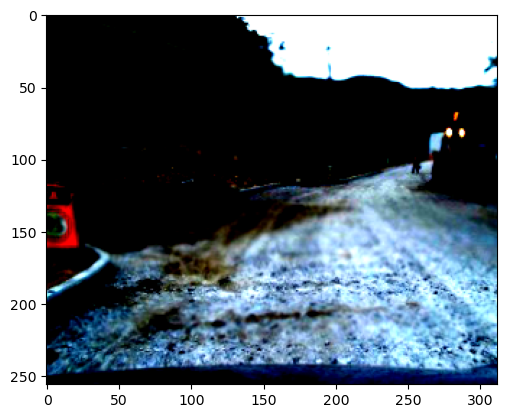

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 312])
tensor(1) asphalt_good


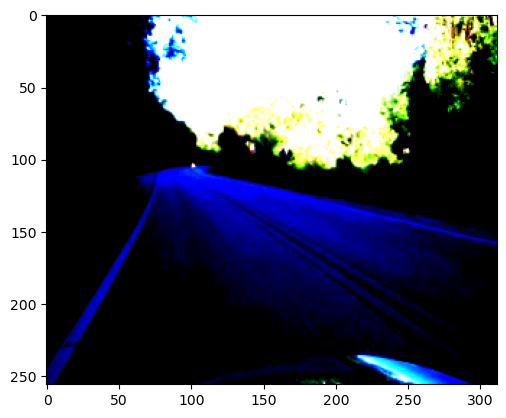

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 312])
tensor(7) unpaved_regular


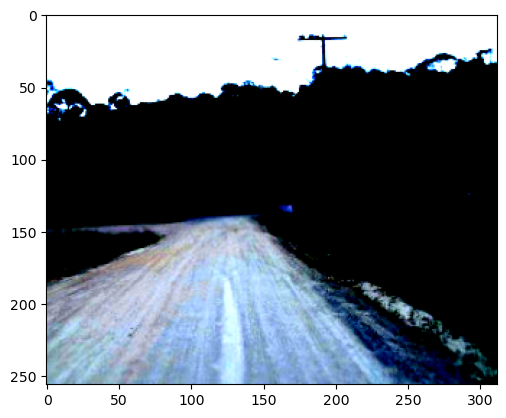

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 312])
tensor(6) unpaved_bad


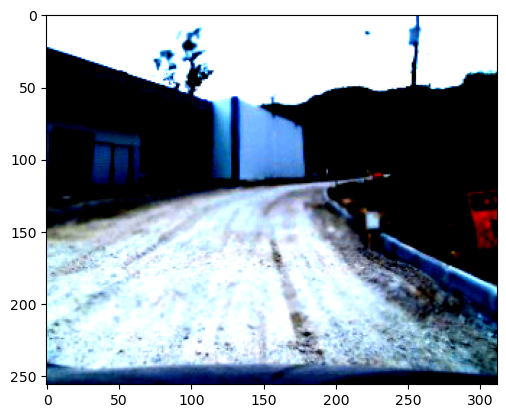

In [13]:
inp_im, inp_label = next(iter(dl_train))

for inp_im_i, inp_label_i in zip(inp_im, inp_label):
    print(inp_im_i.shape)
    print(inp_label_i, id2class[inp_label_i.item()])
    plt.imshow(inp_im_i.permute(1,2,0)); 
    plt.show();

A gente vai usar também a arquitetura ResNet para essa solução. Podemos instanciar a rede diretamente do torch.hub. Um importante detalhe, sempre use o argumento da rede pre-treinada. Uma rede pré-treinada quer dizer que seus pesos já foram ajustados previamente em uma outra tarefa mais genérica, como classificação de imagens no famoso dataset ImageNet ou técnicas de self-supervising learning como o DinoV2. O modelo pre-treinado é o que permite que a gente treine a rede de forma rápida para um a outra tarefa, como no nosso caso, para a classificação de superfície nos dados RTK.

In [14]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet

Using cache found in /home/rafael/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rafael/anaconda3/envs/general/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/rafael/anaconda3/envs/general/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

A gente precisa mudar o *head* da rede, a fim que ela atenda o comprimento do arranjo de classes.

In [15]:
resnet.fc = nn.Linear(512, len(classnames))

Instanciamos também o otimizador da rede, uma escolha padrão é o uso do **AdamW**. O otimizador ele é responsável por atualizar o peso das redes. Também, instanciamos a função perda da rede, no caso de classificação de imagem em multiclasses, usa-se a função de entropia cruzada `nn.CrossEntropyLoss`. A função perda é uma métrica de erro, sobre a qual são computadas gradientes usando-se *backpropagation*; esses gradientes então tem seus valores ajustados de acordo com técnicas propostas por cada otimizador, e então o valor ajustado é incrementado ao valor corrente do peso com a função `opt.step()`, atualizando-se os valores da rede.

In [16]:
opt = torch.optim.AdamW(resnet.parameters(), lr=1e-4)

cross_entropy = nn.CrossEntropyLoss(reduce='mean')

/home/rafael/anaconda3/envs/general/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [17]:
iterations = 1000
print_every_n = 100

it = 0
lossi = []

resnet.train()

# O treinamento seguirá até completar o número assinalado de iterações.
while it < iterations:
    
    for inp_im, inp_label in dl_train:
        inp_im = inp_im.cuda()
        inp_label = inp_label.cuda()

        pred = resnet(inp_im)
        loss = cross_entropy(pred, inp_label)

        # Zero previous gradients saved in the optimizer.
        opt.zero_grad(set_to_none=True)
        # Apply backpropagation, ie., compute new gradients
        loss.backward()
        # Update network weights
        opt.step()
        
        lossi.append(loss.item())
        
        it += 1
        if it >= iterations:
            break
            
        # Captura a info dos últimos valores de losses e computa a média.
        if it % print_every_n == 0:
            loss_avg = lossi[-print_every_n:]
            loss_avg = np.mean(loss_avg)
            print(f'it: {it}\t loss: {loss_avg:.3f}')

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

Depois de treinado podemos conferir a performance no conjunto de validação, isto é, imagens que não foram observadas durante o treinamento, e vamos medir a acurácia também.

In [ ]:
transformations = T.Compose([
    T.Resize(256),
    T.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]),
    # T.RandomHorizontalFlip(0.5)
])


ds_val = SimpleDataset(valpaths, transformations=transformations)
dl_val = DataLoader(ds_val, batch_size=4, drop_last=False)

In [ ]:
resnet.eval()

preds = []
labels = []


for inp_im, inp_label in dl_val:
    inp_im = inp_im.cuda()
    inp_label = inp_label.cuda()

    with torch.no_grad():
        pred = resnet(inp_im)
    
    # A predição da rede é um valor de probabilidade não-normalizado, chamado de *logits*, para cada classe
    # a classe que detém o maior valor de logits, é a classe final da predição.
    pred = pred.argmax(1)
    
    preds.append(pred)
    labels.append(inp_label)

In [ ]:
preds = torch.concat(preds)
labels = torch.concat(labels)

# Transformamos os vetores preds e labels para formato numpy
preds = preds.cpu().numpy()
labels = labels.cpu().numpy()

A gente pode computar a acurácia de forma direta:

In [ ]:
acc = (preds == labels).mean()
print(f'Acurácia: {acc*100:.1f}%')

Contudo, quando temos um problema multi-classe, usa-se outras métricas estatísticas para mensurar a qualidade do sistema, entre elas, podemos usar a matrix de confusão, a fim de sumarizar o balanço de predições pelas amostras de diferentes classes.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_predictions(
    labels, preds, display_labels=classnames, xticks_rotation='vertical')

# Segmentação Semântica

A tarefa de segmentação semântica é assinalar uma classe a cada pixel da imagem, sendo assim podendo destacar os principais elementos da imagem. Para essa tarefa, novamente, vamos usar uma versão do dataset de RTK. Dentro da pasta `RTK/` há dois arquivos `trainpaths.txt` e `valpaths.txt` que separam os arquivos entre os conjuntos de treinamento e validação.

In [ ]:
# !wget https://data.mendeley.com/public-files/datasets/hssswvmjwf/files/2c72e75d-1f50-457a-86f0-a5e3a4174df9/file_downloaded -O rtk-segmentation.zip
# !unzip -d. rtk-segmentation.zip
!ls RTK/

In [ ]:
!head RTK/trainpaths.txt

In [ ]:
def read_rtk_txtfile(fpath):
    with open(fpath, 'r') as f:
        impaths = f.read().split('\n')
        if impaths[-1] == '':
            impaths = impaths[:-1]
            
    impaths = [os.path.join('RTK', p) for p in impaths]
    return impaths


trainpaths = read_rtk_txtfile('RTK/trainpaths.txt')
valpaths = read_rtk_txtfile('RTK/valpaths.txt')


print(f'Number of training samples: {len(trainpaths)}')
print(f'Number of validation samples: {len(valpaths)}')

A fim de usar o dataset pra segmentação semântica, a gente precisa novamente criar instanciar um tipo de classe Dataset, que dessa vez terá um pouco mais de complexidade do que a tarefa de classificação. A diferença no tratamento do dataset de segmentação para o tratamento de classificação é que dessa vez a gente precisa ler um arquivo de imagem também para o rótulo da imagem, *label*. O rótulo é uma imagem de mesma dimensão da imagem de entrada (o cenário) e assinala uma classe para cada pixel dessa imagem. A classe é um índice inteiro, e que no caso desse dataset, os indíces vão de 0 a 12.

In [ ]:
rtk_classnames = [(0, 'background'), (1, 'roadAsphalt'), (2, 'roadPaved'), (3, 'roadUnpaved'), (4, 'roadMarking'),
                  (5, 'speedBump'), (6, 'catsEye'), (7, 'stormDrain'), (8, 'manholeCover'), (9, 'patch'),
                  (10, 'waterPuddle'), (11, 'pothole'), (12, 'crack')]


rtk_name2id = {i:n for i, n in rtk_classnames}
rtk_id2name = {n:i for i, n in rtk_classnames}


def set_randomseed(seed=None, return_seed=False):

    if seed is None:
        seed = np.random.randint(2147483647)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if return_seed:
        return seed
    
    
class SegmentationDataset(Dataset):

    def __init__(self, impaths, transformations=None, transform_target=None):

        self.impaths = impaths
        self.transformations = transformations
        self.normalize = T.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
        
    def __len__(self):
        return len(self.impaths)

    def __getitem__(self, idx):
        impath = self.impaths[idx]
        im = read_image(impath)

        if self.transformations:
            state = set_randomseed(return_seed=True)
            im = self.transformations(im)

        im = self.normalize(im/255)

        labelpath = impath.replace('/image/', '/label/')
        label = read_image(labelpath)
        
        if self.transformations:
            # Seed é importante para garantir que a transformada tanto na imagem
            # quanto na label são iguais.
            set_randomseed(seed=state)
            label = self.transformations(label)

        return im, label[0].long()

Aqui instanciamos então as classes, e algumas transformadas são aplicadas a imagens a fim de ampliar nosso dataset de 560 imagens. As imagens tem resolução original de (352, 288), e faremos um recorte *crop* nelas de (224, 224).

In [ ]:
transformations = T.Compose([
    T.RandomCrop(size=(224, 224)),
    T.RandomHorizontalFlip(p=.5)
])


ds_train = SegmentationDataset(impaths=trainpaths, transformations=transformations)
dl_train = DataLoader(ds_train, batch_size=4)

In [ ]:
inp_im, inp_label = next(iter(dl_train))


for inp_im_i, inp_label_i in zip(inp_im, inp_label):
    print(inp_im_i.shape, inp_label_i.shape)
    # print(inp_label_i, id2class[inp_label_i.item()])
    inp_im_i_unnormalized = normalize_back(inp_im_i).permute(1,2,0)
    
    plt.subplot(121)
    plt.imshow(inp_im_i_unnormalized); 
    plt.subplot(122)
    plt.imshow(inp_label_i)
    plt.show();

A rede usada para treinamento dessa vez é a UNet, uma arquitetura clássica na área de visão originada em 2015, que até hoje mantém-se relevante, principalmente para ter-se um primeiro resposta na solução de um problema. A Unet é composta por duas partes: o *encoder* e o *decoder*. O *encoder* dela é por padrão uma ResNet, igual a rede que usamos pra resolver o problema de classificação. Instanciamos essa arquitetura do módulo `segmentation_models_pytorch`.


In [ ]:
!pip install segmentation_models_pytorch

Detalhe importante, o número de classes da rede são as classes de saída, que nesse problema são 13!

In [ ]:
import segmentation_models_pytorch as smp

unet = smp.Unet(
    encoder_name="resnet18", encoder_weights="imagenet",
    in_channels=3, classes=len(rtk_classnames))

unet.cuda()

Em linhas gerais, o treinamento do problema de segmentação semântica é análogo ao de classificação de imagem, o que muda é que a saída ao invés de ser dada por um único neurônio, ela é dada por um arranjo espacial 2D de neurônios. Todo os procedimentos de iteração vistos acima da computação de perda com a função de entropia cruzada e a atualização de pesos com o otimizador AdamW mantêm-se igual.

In [ ]:
opt = torch.optim.AdamW(unet.parameters(), lr=1e-4)

cross_entropy = nn.CrossEntropyLoss(reduce='mean')

In [ ]:
pred.shape, inp_label.shape

In [ ]:
iterations = 1000
print_every_n = 10

it = 0
lossi = []

resnet.train()

# O treinamento seguirá até completar o número assinalado de iterações.
while it < iterations:
    
    for inp_im, inp_label in dl_train:
        inp_im = inp_im.cuda()
        inp_label = inp_label.cuda()

        pred = unet(inp_im)
        loss = cross_entropy(pred, inp_label)

        # Zera os gradientes prévios guardados.
        opt.zero_grad(set_to_none=True)
        # Aplicar backpropagation, computando novos gradientes.
        loss.backward()
        # Atualiza os pesos da rede.
        opt.step()
        
        lossi.append(loss.item())
        
        it += 1
        if it >= iterations:
            break
            
        # Captura a info dos últimos valores de losses e computa a média.
        if it % print_every_n == 0:
            loss_avg = lossi[-print_every_n:]
            loss_avg = np.mean(loss_avg)
            print(f'it: {it}\t loss: {loss_avg:.3f}')

Depois de treinado, a gente pode verificar como essa rede performa nos dados de treinamento e de validação, novamente, o processo é muito parecido com o de classificação. Note que pare o conjunto de validação nenhuma *transformation* é usada, pois, o intuito do conjunto de validação é avaliar o exato input de entrada.

In [ ]:
ds_val = SegmentationDataset(impaths=trainpaths, transformations=None)
dl_val = DataLoader(ds_val, batch_size=4)

Uma demanda quando trabalhamos com segmentação semântica é visualizarmos a predição em cores, pois a rede predita inteiros, e não valores RGB. Então, criamos as funções abaixo para mapear um índice inteiro a uma cor.

In [ ]:

class Colorizer:

    def __init__(self, n_classes):
        range_ = np.linspace(0, 1, n_classes)
        colors = color_palette('gist_rainbow', as_cmap=True)(range_)
        colors = colors[np.random.permutation(len(colors))]
        colors = colors[..., :3]
        colors = np.concatenate([np.array([[0, 0, 0]]), colors])
        self.colors = colors

    def __call__(self, classmap):
        return self.colors[classmap]


class TorchColorizer(Colorizer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.colors = torch.Tensor(self.colors)

    def __call__(self, classmap):
        tmp = self.colors[classmap]
        return tmp.permute(0, 4, 2, 3, 1)[..., 0]    

Agora de fato, preditamos amostras com nossa rede treinada.

In [ ]:
float2int = lambda x: (x * 255).round().clip(0, 255).astype(uint8)

unet.eval()

preds = []
labels = []


inp_im, inp_label = next(iter(dl_val))
inp_im = inp_im.cuda()
inp_label = inp_label.cuda()

with torch.no_grad():
    pred = unet(inp_im)

# A predição da rede é um valor de probabilidade não-normalizado, chamado de *logits*, para cada classe
# a classe que detém o maior valor de logits, é a classe final da predição.
pred = pred.argmax(1, keepdim=True)

Agora, a gente aplica alguns truques para conseguir visualizar nossa predição.

In [ ]:
colorizer = TorchColorizer(len(rtk_classnames))

pred_color = colorizer(pred)
im = normalize_back(inp_im).cpu()
blend = im * pred_color

tmp = [im, pred_color, blend]
tmp = torch.concat(tmp, axis=3)
tmp = tmp.permute(1,0,2,3)
tmp = tmp.flatten(1,2)
tmp = tmp.permute(1,2,0).cpu().numpy()
tmp = (tmp*255).clip(0,255).astype(np.uint8)
Image.fromarray(tmp)

# Detecção de Objetos